# Tensorflow: Basic Text Classification - Binary Label
* Reference: https://www.tensorflow.org/tutorials/keras/text_classification

## Setup

In [228]:
import io, os, re, shutil
import string
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, losses

## Download the IMDB Dataset

In [3]:
# Download the dataset to be used
IMDB_MOVIE_REVIEW_DATA_URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file(
    "aclImdb_v1.tar.gz", IMDB_MOVIE_REVIEW_DATA_URL,
    untar=True, cache_dir='.', cache_subdir='')

84140032/84125825 [==============================] - 10s 0us/step


In [4]:
# Get the directory name of the dataset
dataset_dir = os.path.join( os.path.dirname(dataset), 'aclImdb' )
# os.listdir(dataset_dir)

In [6]:
# Get the directory name of the training data
train_dir = os.path.join(dataset_dir, 'train')
# os.listdir(train_dir)

In [7]:
# Remove directory containing unsupervised examples
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [14]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
            'aclImdb/train', batch_size=batch_size,
            validation_split=0.2, subset='training',
            seed=seed)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
            'aclImdb/train', batch_size=batch_size,
            validation_split=0.2, subset='validation',
            seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [15]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(2):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [16]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [17]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
            'aclImdb/test', batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Text Preprocessing

In [19]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    stripped_punct = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')
    return stripped_punct

In [59]:
# Vocabulary size (features) and number of words in a sequence (review).
max_features = 10000
sequence_length = 250

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = layers.TextVectorization(
                    standardize=custom_standardization,
                    max_tokens=max_features,
                    output_mode='int',
                    output_sequence_length=sequence_length)

In [60]:
# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [61]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [62]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'I love horror movies that brings out a real amount of mystery like say "silent hill" ( which i found to be quite good, but still, was missing something ) and movies that keeps you guessing, this i thought was one of those movies. At first the movie starts out with some really good suspense and builds up a good starting point for a good horror scene, but after that it just rolls down the hill and from there it only goes faster and faster down. I mentioned silent hill at first for a reason because i can see a lot of "stolen" themes from that movie in here.. All in all i would say, watch silent hill instead of this one, its better, its more scary, it has a lot more suspense and also the ending is a lot better.. And best of all, you wont feel ripped off as i did with this one.. This just seems to be one of those "i like that movie so I\'m gonna re-make it in my own really bad version" kinda movie.. Oh and one more thing... Lordi.. in a horror movie... thats like trying t

In [63]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  lovely
 313 --->  american
Vocabulary size: 10000


In [64]:
# Create vectorized training, validation, and test datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [80]:
[ x for x in train_ds.take(1).as_numpy_iterator() ]
# print(dir(train_ds))

[(array([[   1,   35,  215, ...,    0,    0,    0],
         [3089,  226,    3, ...,    0,    0,    0],
         [  10,  139,   25, ...,    0,    0,    0],
         ...,
         [  85,  686,   42, ...,    0,    0,    0],
         [   2, 3136,   65, ...,    0,    0,    0],
         [   4,  181,  246, ...,    0,    0,    0]], dtype=int64),
  array([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
         0, 0, 0, 0, 0, 0, 1, 1, 0, 0]))]

## Configure the Dataset for Performance

In [81]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create a Classification Model

In [83]:
embedding_dim = 16
model = tf.keras.Sequential( [
    layers.Embedding( max_features+1, embedding_dim ),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


## Compile and Train the Model

In [131]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
LOGS_ROOTDIR = os.path.join('.', 'logs')
this_run_log_dir = os.path.join( LOGS_ROOTDIR, "fit_" + dt.datetime.now().strftime("%Y%m%d-%H%M%S") )
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=this_run_log_dir, histogram_freq=1)
print(f"Prepared log dir: {this_run_log_dir}")

# Stop epochs if validation loss is increasing
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Prepared log dir: .\logs\fit_20211118-160535


In [132]:
model.compile(
    optimizer='adam',
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
    )

In [133]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback, earlystopping_callback]
)

Epoch 1/10
625/625 [==============================] - 6s 8ms/step - loss: 0.1063 - binary_accuracy: 0.9667 - val_loss: 0.3370 - val_binary_accuracy: 0.8776
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1030 - binary_accuracy: 0.9674 - val_loss: 0.3424 - val_binary_accuracy: 0.8776
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0980 - binary_accuracy: 0.9708 - val_loss: 0.3489 - val_binary_accuracy: 0.8784
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0934 - binary_accuracy: 0.9731 - val_loss: 0.3555 - val_binary_accuracy: 0.8778
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0892 - binary_accuracy: 0.9742 - val_loss: 0.3609 - val_binary_accuracy: 0.8786
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0861 - binary_accuracy: 0.9757 - val_loss: 0.3688 - val_binary_accuracy: 0.8770
Epoch 7/10
625/625 [==============================] - 3s 5ms/ste

## Evaluate the Model

In [134]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 954us/step - loss: 0.4803 - binary_accuracy: 0.8500
Loss:  0.480336993932724
Accuracy:  0.8500400185585022


In [135]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

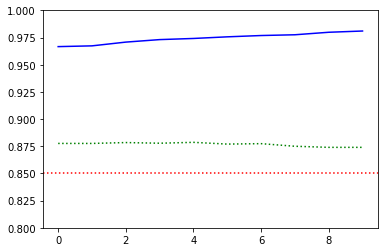

In [183]:
plt.plot( 'binary_accuracy', 'b-', data=history.history )
plt.plot( 'val_binary_accuracy', 'g:', data=history.history )
# plt.plot( [accuracy]*len(history.history['binary_accuracy']), 'r--', data=history.history )
y_axis_min_val = max( 0.5, round(min(accuracy, min(history.history['val_binary_accuracy']), min(history.history['binary_accuracy']) )-0.1, 1) )
_ = plt.ylim( y_axis_min_val, 1.0)
plt.axhline( accuracy, color='r', linestyle=':')

In [184]:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 23932), started 1 day, 1:11:45 ago. (Use '!kill 23932' to kill it.)

## Export the Model

In [197]:
# Wrap the trained model to permit it to be used directly in input strings (vs. vectors)
# and then apply an activation layer to yield a floating result between 0 and 1
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
    ])

export_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_3 (TextVe (None, 250)               0         
_________________________________________________________________
sequential (Sequential)      (None, 1)                 160033    
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [198]:
export_model.compile(
    optimizer="adam",
    loss=losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
    )

In [199]:
# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.4803 - accuracy: 0.8500
0.8500400185585022


In [256]:
examples = [
  "This movies is 10 of 10 stars.",
  "This movies is 9 of 10 stars.",
  "This movies is 8 of 10 stars.",
  "This movies is 7 of 10 stars.",
  "This movies is 6 of 10 stars.",
  "This movies is 5 of 10 stars.",
  "This movies is 4 of 10 stars.",
  "This movies is 3 of 10 stars.",
  "This movies is 2 of 10 stars.",
  "This movies is 1 of 10 stars.",
  "This movies is all good.",
  "This movies is not at all good.",
  "This movies is 5 stars.",
  "This movies is 4 stars.",
  "This movies is 3 stars.",
  "This movies is 2 stars.",
  "This movies is 1 stars.",
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

preds = export_model.predict(examples).flatten()
r_df = pd.DataFrame( {'Review': examples, 'Rating': preds} )
r_df = r_df.sort_values(by='Rating', ascending=False).reset_index(drop=True)
r_df

,Review,Rating
0,This movies is 8 of 10 stars.,0.826285
1,This movies is 7 of 10 stars.,0.778393
2,This movies is 10 of 10 stars.,0.663508
3,This movies is 5 of 10 stars.,0.626547
4,The movie was great!,0.617263
5,This movies is 9 of 10 stars.,0.614599
6,This movies is 2 of 10 stars.,0.569792
7,This movies is 5 stars.,0.554164
8,This movies is all good.,0.546045
9,This movies is 2 stars.,0.495270


## Retrieve the Trained Word Embeddings and Save them to Disk

In [27]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [28]:
with io.open('./data/vectors.tsv', 'w', encoding='utf-8') as out_v:
    with io.open('./data/metadata.tsv', 'w', encoding='utf-8') as out_m:
        for index, word in enumerate(vocab):
            if index == 0:
                continue    # skip 0, it's padding
                
            vec = weights[index]
            out_v.write( '\t'.join( [ str(x) for x in vec ]) + '\n' )
            out_m.write( word + '\n' )


## Visualize the Embeddings
* Tensorflow Embedding Projector: http://projector.tensorflow.org/
* Click on "Load data".
* Upload the two files you created above: vecs.tsv and meta.tsv.